In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import random 
import math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
# Block - Data Pre-processing 

csv_data = pd.read_csv('input/ML_data.csv')
csv_data.info()

train_X, test_X, train_y, test_y = train_test_split(csv_data.Canonical_STRONGs, csv_data.formation_energy, test_size = 0.25, random_state = 42)
train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

print(train_X[1])
print(test_X[15])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20812 entries, 0 to 20811
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pore_number            20812 non-null  int64  
 1   pore_N                 20812 non-null  int64  
 2   Canonical_STRONGs      20812 non-null  object 
 3   formation_time         20812 non-null  float64
 4   formation_probability  20812 non-null  float64
 5   formation_energy       20812 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 975.7+ KB
AAFFFSFZFFZFFAAFFFZFZFAAFFFZFZFFZFF
AAFFFZFFASFZFFZFFZFAAFFFZFZFFZFZFF


In [3]:
# Block - Data pre-processing (tokenization)

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = None, # maximum number of words to keep
    filters="", #find each character after other  
    char_level=True # treat each character as token
)

# updates internal vocabulary based on a list of texts, required before using texts_to_sequences
tokenizer.fit_on_texts(train_X)

In [4]:
# Block - Data pre-processing (padding)

# transforms each text in texts to a sequence of integers, padded to a length of 50
max_len = csv_data.Canonical_STRONGs.map(lambda x: len(x)).max()

train_X = tokenizer.texts_to_sequences(train_X)
padded_train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, padding="post", maxlen = max_len)
test_X = tokenizer.texts_to_sequences(test_X)
padded_test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, padding="post", maxlen = max_len)

print(padded_train_X[1])
print(padded_test_X[15])

[3 3 1 1 1 4 1 2 1 1 2 1 1 3 3 1 1 1 2 1 2 1 3 3 1 1 1 2 1 2 1 1 2 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[3 3 1 1 1 2 1 1 3 4 1 2 1 1 2 1 1 2 1 3 3 1 1 1 2 1 2 1 1 2 1 2 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


# Hyperparameter Tuning

In [5]:
# K-Fold Cross validation for hyperparameter tuning
vocab_size = 6

def create_model(embedding_dim, gru_units, dense_units, activation):
    # building the model
    model = tf.keras.Sequential()
    # make embedding and indicate that 0 should be treated as padding mask i.e. to ignore 0's
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True))
    model.add(tf.keras.layers.GRU(gru_units))
    
    for units in dense_units:
        model.add(tf.keras.layers.Dense(units=units, activation=activation))
    
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics = tf.metrics.MeanAbsoluteError())
    return model
   

In [6]:
# Parameter Grid to be tuned

param_grid = {
    'embedding_dim':[8, 16, 32],
    'gru_units': [16, 32, max_len],
    'dense_units':[[max_len,32,16,8,4],[max_len,36,24,12,8,4],[max_len,40,32,24,16,8,4]],
    'activation': ['relu','tanh'], 
}

In [7]:
# Grid search CV (5 fold)

# create the KerasRegressor warpper with the RNN model function
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the cross-validation strategy (K-fold)
cross_validation = KFold(n_splits=5)

# define the GridSearchCV with the model, hyperparameters, and cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= cross_validation, scoring='r2')

C:\Users\91739\AppData\Local\Temp\ipykernel_10204\3510641784.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [8]:
grid_search.fit(padded_train_X, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002445A6BC640>,
             param_grid={'activation': ['relu', 'tanh'],
                         'dense_units': [[48, 32, 16, 8, 4],
                                         [48, 36, 24, 12, 8, 4],
                                         [48, 40, 32, 24, 16, 8, 4]],
                         'embedding_dim': [8, 16, 32],
                         'gru_units': [16, 32, 48]},
             scoring='r2')

In [9]:
# Print the best hyperparameters and corresponding R2 score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best R2 Score: ", grid_search.best_score_)

Best Hyperparameters:  {'activation': 'relu', 'dense_units': [48, 40, 32, 24, 16, 8, 4], 'embedding_dim': 16, 'gru_units': 16}
Best R2 Score:  0.06110655074472684


# Developed Sequential Model

In [10]:
# Sequential model developed using hyperparameter obtained from k-fold cross validation

model = tf.keras.Sequential()
 
model.add(tf.keras.layers.Embedding(input_dim=6, output_dim=16, mask_zero=True))

model.add(tf.keras.layers.GRU(max_len))
   
# ANN start layer
model.add(tf.keras.layers.Dense(max_len, activation="relu"))
model.add(tf.keras.layers.Dense(40, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(24, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="relu"))
    
# regression, so no activation
model.add(tf.keras.layers.Dense(1))
    
# compile the model
model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics = tf.metrics.MeanAbsoluteError())
    
# train the model
model_history = model.fit(padded_train_X, train_y, batch_size=32, epochs=500)

Epoch 1/500
488/488 [==============================] - 13s 20ms/step - loss: 172978.2969 - mean_absolute_error: 232.4883
Epoch 2/500
488/488 [==============================] - 10s 20ms/step - loss: 5733.7153 - mean_absolute_error: 54.7406
Epoch 3/500
488/488 [==============================] - 10s 20ms/step - loss: 355.4249 - mean_absolute_error: 13.5806
Epoch 4/500
488/488 [==============================] - 10s 20ms/step - loss: 266.6401 - mean_absolute_error: 11.8732
Epoch 5/500
488/488 [==============================] - 10s 20ms/step - loss: 231.3266 - mean_absolute_error: 11.1055
Epoch 6/500
488/488 [==============================] - 10s 20ms/step - loss: 197.6665 - mean_absolute_error: 10.2529
Epoch 7/500
488/488 [==============================] - 10s 20ms/step - loss: 178.9262 - mean_absolute_error: 9.6891
Epoch 8/500
488/488 [==============================] - 10s 20ms/step - loss: 178.2000 - mean_absolute_error: 9.7561
Epoch 9/500
488/488 [==============================] - 10s 20

488/488 [==============================] - 11s 24ms/step - loss: 90.5527 - mean_absolute_error: 6.3886
Epoch 72/500
488/488 [==============================] - 11s 23ms/step - loss: 85.8643 - mean_absolute_error: 6.0968
Epoch 73/500
488/488 [==============================] - 11s 23ms/step - loss: 85.7067 - mean_absolute_error: 6.0366
Epoch 74/500
488/488 [==============================] - 11s 23ms/step - loss: 83.7792 - mean_absolute_error: 6.0515
Epoch 75/500
488/488 [==============================] - 11s 23ms/step - loss: 92.3282 - mean_absolute_error: 6.5912
Epoch 76/500
488/488 [==============================] - 12s 24ms/step - loss: 91.3546 - mean_absolute_error: 6.4482
Epoch 77/500
488/488 [==============================] - 12s 24ms/step - loss: 87.1032 - mean_absolute_error: 6.2810
Epoch 78/500
488/488 [==============================] - 12s 24ms/step - loss: 75.7591 - mean_absolute_error: 5.5638
Epoch 79/500
488/488 [==============================] - 12s 24ms/step - loss: 82.6498

488/488 [==============================] - 12s 24ms/step - loss: 66.0238 - mean_absolute_error: 5.4395
Epoch 142/500
488/488 [==============================] - 12s 24ms/step - loss: 61.2334 - mean_absolute_error: 5.1607
Epoch 143/500
488/488 [==============================] - 12s 24ms/step - loss: 55.5420 - mean_absolute_error: 4.7385
Epoch 144/500
488/488 [==============================] - 12s 24ms/step - loss: 57.5656 - mean_absolute_error: 4.9256
Epoch 145/500
488/488 [==============================] - 12s 24ms/step - loss: 57.0625 - mean_absolute_error: 4.9448
Epoch 146/500
488/488 [==============================] - 12s 24ms/step - loss: 58.2120 - mean_absolute_error: 5.0904
Epoch 147/500
488/488 [==============================] - 11s 23ms/step - loss: 71.9123 - mean_absolute_error: 5.9935
Epoch 148/500
488/488 [==============================] - 11s 24ms/step - loss: 56.3876 - mean_absolute_error: 4.9394
Epoch 149/500
488/488 [==============================] - 12s 24ms/step - loss:

488/488 [==============================] - 13s 27ms/step - loss: 48.4013 - mean_absolute_error: 4.5225
Epoch 212/500
488/488 [==============================] - 12s 24ms/step - loss: 52.7216 - mean_absolute_error: 4.8560
Epoch 213/500
488/488 [==============================] - 12s 24ms/step - loss: 46.3855 - mean_absolute_error: 4.2710
Epoch 214/500
488/488 [==============================] - 12s 24ms/step - loss: 50.5327 - mean_absolute_error: 4.6325
Epoch 215/500
488/488 [==============================] - 12s 24ms/step - loss: 52.5362 - mean_absolute_error: 4.7537
Epoch 216/500
488/488 [==============================] - 12s 24ms/step - loss: 52.4451 - mean_absolute_error: 4.7833
Epoch 217/500
488/488 [==============================] - 12s 24ms/step - loss: 50.3947 - mean_absolute_error: 4.6915
Epoch 218/500
488/488 [==============================] - 12s 24ms/step - loss: 49.6609 - mean_absolute_error: 4.5813
Epoch 219/500
488/488 [==============================] - 12s 24ms/step - loss:

488/488 [==============================] - 12s 25ms/step - loss: 43.0385 - mean_absolute_error: 4.1631
Epoch 282/500
488/488 [==============================] - 12s 25ms/step - loss: 46.7538 - mean_absolute_error: 4.4752
Epoch 283/500
488/488 [==============================] - 12s 25ms/step - loss: 43.8367 - mean_absolute_error: 4.2447
Epoch 284/500
488/488 [==============================] - 12s 24ms/step - loss: 48.9188 - mean_absolute_error: 4.6810
Epoch 285/500
488/488 [==============================] - 12s 25ms/step - loss: 48.1724 - mean_absolute_error: 4.5850
Epoch 286/500
488/488 [==============================] - 12s 26ms/step - loss: 46.0598 - mean_absolute_error: 4.4339
Epoch 287/500
488/488 [==============================] - 12s 25ms/step - loss: 42.6836 - mean_absolute_error: 4.1940
Epoch 288/500
488/488 [==============================] - 12s 25ms/step - loss: 47.7610 - mean_absolute_error: 4.6681
Epoch 289/500
488/488 [==============================] - 12s 24ms/step - loss:

488/488 [==============================] - 11s 22ms/step - loss: 39.8334 - mean_absolute_error: 4.0045
Epoch 352/500
488/488 [==============================] - 10s 21ms/step - loss: 34.4060 - mean_absolute_error: 3.5830
Epoch 353/500
488/488 [==============================] - 10s 21ms/step - loss: 41.4623 - mean_absolute_error: 4.2774
Epoch 354/500
488/488 [==============================] - 10s 20ms/step - loss: 39.2262 - mean_absolute_error: 4.1390
Epoch 355/500
488/488 [==============================] - 10s 20ms/step - loss: 39.7793 - mean_absolute_error: 4.1370
Epoch 356/500
488/488 [==============================] - 10s 21ms/step - loss: 37.6371 - mean_absolute_error: 3.9221
Epoch 357/500
488/488 [==============================] - 10s 20ms/step - loss: 38.5352 - mean_absolute_error: 3.9160
Epoch 358/500
488/488 [==============================] - 10s 20ms/step - loss: 39.3315 - mean_absolute_error: 4.0847
Epoch 359/500
488/488 [==============================] - 10s 20ms/step - loss:

488/488 [==============================] - 12s 25ms/step - loss: 34.6988 - mean_absolute_error: 3.8128
Epoch 422/500
488/488 [==============================] - 12s 26ms/step - loss: 37.2521 - mean_absolute_error: 4.0083
Epoch 423/500
488/488 [==============================] - 13s 27ms/step - loss: 36.1143 - mean_absolute_error: 3.8459
Epoch 424/500
488/488 [==============================] - 12s 25ms/step - loss: 37.4569 - mean_absolute_error: 4.1287
Epoch 425/500
488/488 [==============================] - 12s 24ms/step - loss: 32.7883 - mean_absolute_error: 3.5878
Epoch 426/500
488/488 [==============================] - 12s 25ms/step - loss: 34.9048 - mean_absolute_error: 3.8552
Epoch 427/500
488/488 [==============================] - 12s 24ms/step - loss: 32.7456 - mean_absolute_error: 3.6725
Epoch 428/500
488/488 [==============================] - 12s 24ms/step - loss: 34.9609 - mean_absolute_error: 3.8197
Epoch 429/500
488/488 [==============================] - 12s 24ms/step - loss:

488/488 [==============================] - 14s 30ms/step - loss: 35.5821 - mean_absolute_error: 3.9993
Epoch 492/500
488/488 [==============================] - 16s 32ms/step - loss: 34.0618 - mean_absolute_error: 3.9245
Epoch 493/500
488/488 [==============================] - 15s 30ms/step - loss: 29.9776 - mean_absolute_error: 3.5884
Epoch 494/500
488/488 [==============================] - 14s 29ms/step - loss: 28.5858 - mean_absolute_error: 3.3962
Epoch 495/500
488/488 [==============================] - 13s 26ms/step - loss: 32.4923 - mean_absolute_error: 3.8019
Epoch 496/500
488/488 [==============================] - 13s 28ms/step - loss: 28.8640 - mean_absolute_error: 3.4066
Epoch 497/500
488/488 [==============================] - 14s 29ms/step - loss: 29.0732 - mean_absolute_error: 3.4328
Epoch 498/500
488/488 [==============================] - 14s 29ms/step - loss: 31.4757 - mean_absolute_error: 3.6537
Epoch 499/500
488/488 [==============================] - 14s 29ms/step - loss:

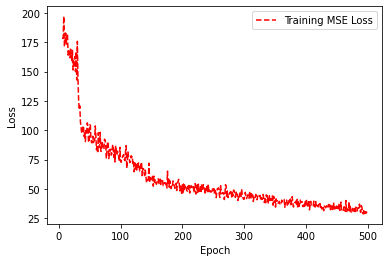

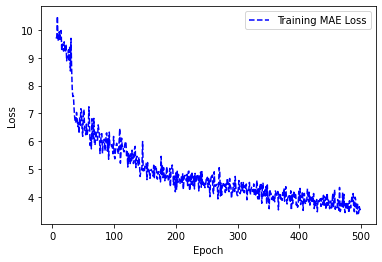

In [11]:
# plotting mse loss
training_mse_loss = model_history.history['loss']
training_mae_loss = model_history.history['mean_absolute_error']

epoch_count = range(6,len(training_mse_loss))

plt.plot(epoch_count, training_mse_loss[6:], 'r--')
plt.legend(['Training MSE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

plt.plot(epoch_count, training_mae_loss[6:], 'b--')
plt.legend(['Training MAE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [12]:
# evaluate on test data
yhat = model.predict(padded_test_X)

# evaluate on train data
yhat_train = model.predict(padded_train_X)

488/488 [==============================] - 3s 7ms/step


test metrics
4.216092565427624
55.27670647750576
0.9942384082148721
train metrics
3.6324194055963313
26.892899315423367
0.9972831636173507


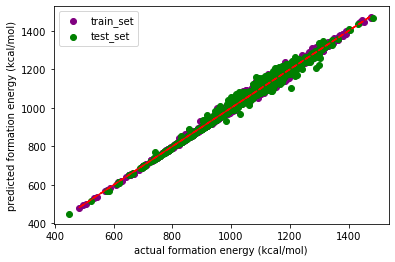

In [13]:
print("test metrics")
mae_test = metrics.mean_absolute_error(test_y,yhat)
mse_test = metrics.mean_squared_error(test_y,yhat)
r2_test = metrics.r2_score(test_y,yhat)

print(mae_test)
print(mse_test)
print(r2_test)

print("train metrics")
mae_train = metrics.mean_absolute_error(train_y,yhat_train)
mse_train = metrics.mean_squared_error(train_y,yhat_train)
r2_train = metrics.r2_score(train_y,yhat_train)

print(mae_train)
print(mse_train)
print(r2_train)

plt.scatter(train_y,yhat_train,color = 'purple')
plt.scatter(test_y,yhat, color = 'green')
plt.plot(train_y,train_y, 'r--')
#plt.title('Parity plot')
plt.ylabel('predicted formation energy (kcal/mol)')
plt.xlabel('actual formation energy (kcal/mol)')
plt.legend(['train_set', 'test_set'])
#plt.savefig("figures/formation_energy/parity_plot.png", format="png", dpi=1600)
plt.show()

# Saving the trained model

In [14]:
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

In [15]:
# save the model to disk
filename = 'output/formation_energy/formation_energy_model.h5'
save_model(model, filename)

# Loading the saved model

In [16]:
# load the model from disk
filename = 'output/formation_energy/formation_energy_model.h5'
loaded_model = load_model(filename)

# Testing the saved model

In [17]:
# evaluate on train and test data
yhat_test_loaded = loaded_model.predict(padded_test_X)
yhat_train_loaded = loaded_model.predict(padded_train_X)


488/488 [==============================] - 3s 7ms/step


In [18]:
print("test metrics")
mae_test = metrics.mean_absolute_error(test_y,yhat_test_loaded)
mse_test = metrics.mean_squared_error(test_y,yhat_test_loaded)
r2_test = metrics.r2_score(test_y,yhat_test_loaded)

print(mae_test)
print(mse_test)
print(r2_test)

print("train metrics")
mae_train = metrics.mean_absolute_error(train_y,yhat_train_loaded)
mse_train = metrics.mean_squared_error(train_y,yhat_train_loaded)
r2_train = metrics.r2_score(train_y,yhat_train_loaded)

print(mae_train)
print(mse_train)
print(r2_train)

test metrics
4.216092565427624
55.27670647750576
0.9942384082148721
train metrics
3.6324194055963313
26.892899315423367
0.9972831636173507


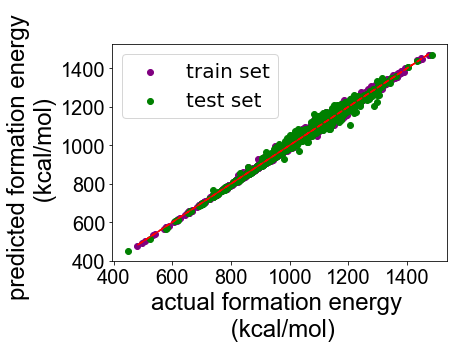

In [19]:
plt.scatter(train_y,yhat_train_loaded,color = 'purple')
plt.scatter(test_y,yhat_test_loaded, color = 'green')
plt.plot(train_y,train_y, 'r--')

plt.ylabel('predicted formation energy \n (kcal/mol)', fontname="Arial", fontsize=24)
plt.xlabel('actual formation energy \n (kcal/mol)', fontname="Arial", fontsize=24)
plt.legend(['train set', 'test set'], fontsize="20" )
plt.xticks(fontsize=20, fontname="Arial")
plt.yticks(fontsize=20, fontname="Arial")
plt.savefig("figures/formation_energy/parity_plot.png", format="png", dpi=1600, bbox_inches='tight')
plt.show()